# Read dataset and create data loaders

In [24]:
# Import torch and CIFAR dataset
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F

# Import matplotlib and numpy for graphs
import matplotlib.pyplot as plt
import numpy as np


In [25]:
'''
Import CIFAR dataset, define labbels and load training and validation dataset
Reference for loading dataset: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
Reference for augmentation: https://pytorch.org/vision/stable/transforms.html
'''
batch_size=64 
print('Batch size:', batch_size)

# Normalisation and std values for RGB in dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation for training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding
    transforms.RandomHorizontalFlip(),    # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomRotation(15),        # Randomly rotate the image by up to 15 degrees
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Randomly translate the image
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),                # Convert image to tensor
    transforms.Normalize(mean=mean, std=std),  # Normalize with mean and std
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))  # Randomly erase a portion of the image (optional)
])

# No augmentation for test set (only normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize with mean and std
])

# Load training and testing datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'lorry')

Batch size: 64
Files already downloaded and verified
Files already downloaded and verified


In [26]:
# # From the PyTorch's tutorial on image classification
# import matplotlib.pyplot as plt
# import numpy as np

# def imshow(img):
#     '''
#     Show an image
#     Input: image file to show
#     Output: image
#     '''
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # Get random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # Show images
# imshow(torchvision.utils.make_grid(images))
# # Print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Main model
Divided as such:


*   **Stem**: takes the images as inputs, extracts features from them
*   **Backbone**: made up of *K* branches, made up of an expert branch
*   **Classifier**: takes input from the last block
*   **Model**: wraps all together







## Stem
*   Takes images as inputs
*   Extracts a feature representation from them

In [27]:
class Stem(nn.Module):
  '''
  Extract features using a Resnet-18 stem
  Reference: Week 09 Lab
  '''
  def __init__(self, input_channels, middle_channels, output_channels):
     super(Stem,self).__init__()
     # Default parameters
     kernel_size=3
     stride=1
     padding=1
     
     # Combine multiple layers
     self.stem = nn.Sequential(
       nn.Conv2d(input_channels, middle_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels), 
       nn.ReLU(inplace=True),
       nn.Conv2d(middle_channels, middle_channels,kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2), # Half the size of the image
       nn.Conv2d(middle_channels, output_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(output_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2) # Half the size of the image
       )

  def forward(self,x):
    x = self.stem(x)
    return x

## Expert Branch

In [28]:
class ExpertBranch(nn.Module):
  '''
  Expert branch predicting vector a with K elements from input tensor X
  '''
  def __init__(self, input_channels, k, r):
    super(ExpertBranch,self).__init__()
    # Spatially pool x
    self.pool= nn.AdaptiveAvgPool2d(1)
    #Forward through fc1, reducing by r
    self.fc1= nn.Linear(input_channels, input_channels//r)
    # Activation function ReLu
    self.relu= nn.ReLU()
    # Forward through fc2
    self.fc2= nn.Linear(input_channels//r,k)

  def forward(self,x):
    # Spatially pool X
    x = self.pool(x)
    # Forward through fc1, reducing by r
    x= x.squeeze(-1).squeeze(-1)
    x = self.fc1(x)
    # Processed through non-linear activation g
    x = F.relu(x)
    # Pass through fc2
    x = self.fc2(x)
    # Forward with softmax
    x = F.softmax(x,dim=1)
    return x

## Block

In [29]:
class Block(nn.Module):
  '''
  Block
  '''
  def __init__(self, input_channels, output_channels, k, r):
    super(Block, self).__init__()

    # Default parameters
    kernel_size=3
    stride=1
    padding=1

    # Set parameters
    self.k= k
    self.expertBranch = ExpertBranch(input_channels, k=k, r=r)

    # Create K convolutional layers
    self.convs= nn.ModuleList([
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride= stride, padding=padding)
        for _ in range(k)
    ])

    # If dimensions do not match
    self.downsample = None
    if input_channels != output_channels:
        self.downsample = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(output_channels)
        )

  def forward(self,x):
    identity= x
    # Vector a from expert branch
    a = self.expertBranch(x)
    # Convolutional layers 
    conv_outputs = [conv(x) for conv in self.convs]
    stacked = torch.stack(conv_outputs, dim=1)

    # Create vector O
    a= a.view(a.size(0), self.k, 1,1,1)
    out = (a* stacked).sum(dim=1)

    # Apply downsampling for mismatched dimensions
    if self.downsample is not None:
        identity = self.downsample(identity)
        
    # Skip connection to stablise gradient descent
    out += identity
    out = F.relu(out) # activation after skip

    return out

## Backbone

In [30]:
class Backbone(nn.Module):
  '''
  N blocks
  '''
  def __init__(self, input_channels, hidden_channels, num_blocks, k, r):
    super(Backbone, self).__init__()
    self.blocks= nn.ModuleList()

    # First block takes input from stem
    self.blocks.append(Block(input_channels, hidden_channels, k=k, r=r))

    # Rest of blocks take input form previous block
    for _ in range(1, num_blocks):
      self.blocks.append(Block(hidden_channels, hidden_channels, k=k, r=r))

  def forward(self, x):
    for idx, block in enumerate(self.blocks):
      x = block(x)
    return x

## Classifier

In [31]:
class Classifier(nn.Module):
  def __init__(self, input_channels, num_classes, use_mlp):
    super(Classifier,self).__init__()
    # Default parameters
    dropout_rate=0.4
    # Spatially pool
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.use_mlp= use_mlp

    if use_mlp:
      self.classifier= nn.Sequential(
          nn.Linear(input_channels, input_channels*2),
          nn.ReLU(),
          nn.Dropout(dropout_rate), # Deeper network with 3 layers
          nn.Linear(input_channels*2, input_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(input_channels, num_classes)
      )
    else:
      self.classifier= nn.Linear(input_channels, num_classes)

  def forward(self, x):
    x = self.pool(x).squeeze(-1).squeeze(-1)
    out = self.classifier(x)
    return out


# Model

In [32]:
class Model(nn.Module):
  def __init__(self, input_channels, output_channels, middle_channels, hidden_channels, num_blocks, k, r, num_classes, use_mlp):
    super(Model, self).__init__()
    # Call stem
    self.stem= Stem(
      input_channels=input_channels,
      middle_channels=middle_channels,
      output_channels=output_channels
    )
    # Call backbone
    self.backbone= Backbone(
      input_channels=output_channels, 
      hidden_channels= hidden_channels, 
      num_blocks=num_blocks,
      k=k, 
      r=r)
    # Call classifier
    self.classifier= Classifier(
      input_channels=hidden_channels, 
      num_classes=num_classes,
      use_mlp= use_mlp)

  def forward(self,x):
    x= self.stem(x)
    x= self.backbone(x)
    x= self.classifier(x)
    return x

# Create the loss and optmiser


In [33]:
model = Model(
    input_channels=3,
    output_channels=128,
    middle_channels=64,
    hidden_channels=256,
    num_blocks=8,
    k=6,
    r=4,
    num_classes=10,
    use_mlp=True
)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=5e-4, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=195)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, 
    schedulers=[warmup_scheduler, main_scheduler],
    milestones=[5]
)

# Training & Testing


Epoch 1/100


Train Loss: 2.1883 | Accuracy: 18.60%
Val   Loss: 1.9603 | Accuracy: 28.26%
Saved best model.

Epoch 2/100


Train Loss: 2.0312 | Accuracy: 25.99%
Val   Loss: 1.8045 | Accuracy: 37.18%
Saved best model.

Epoch 3/100


Train Loss: 1.9507 | Accuracy: 31.00%
Val   Loss: 1.7118 | Accuracy: 41.86%
Saved best model.

Epoch 4/100


Train Loss: 1.8783 | Accuracy: 35.21%
Val   Loss: 1.6950 | Accuracy: 45.11%
Saved best model.

Epoch 5/100


Train Loss: 1.8263 | Accuracy: 38.10%
Val   Loss: 1.5323 | Accuracy: 51.60%
Saved best model.

Epoch 6/100


Train Loss: 1.7826 | Accuracy: 40.55%
Val   Loss: 1.4609 | Accuracy: 56.59%
Saved best model.

Epoch 7/100


Train Loss: 1.7401 | Accuracy: 42.89%
Val   Loss: 1.4168 | Accuracy: 57.35%
Saved best model.

Epoch 8/100


Train Loss: 1.7076 | Accuracy: 44.50%
Val   Loss: 1.3894 | Accuracy: 58.08%
Saved best model.

Epoch 9/100


Train Loss: 1.6762 | Accuracy: 46.29%
Val   Loss: 1.4322 | Accuracy: 55.46%
No improvement for 1 epochs.

Epoch 10/100


Train Loss: 1.6416 | Accuracy: 47.70%
Val   Loss: 1.3135 | Accuracy: 63.22%
Saved best model.

Epoch 11/100


Train Loss: 1.6148 | Accuracy: 49.28%
Val   Loss: 1.3290 | Accuracy: 62.07%
No improvement for 1 epochs.

Epoch 12/100


Train Loss: 1.5874 | Accuracy: 50.39%
Val   Loss: 1.2797 | Accuracy: 64.00%
Saved best model.

Epoch 13/100


Train Loss: 1.5659 | Accuracy: 51.88%
Val   Loss: 1.2202 | Accuracy: 67.76%
Saved best model.

Epoch 14/100


Train Loss: 1.5380 | Accuracy: 52.87%
Val   Loss: 1.2327 | Accuracy: 66.47%
No improvement for 1 epochs.

Epoch 15/100


Train Loss: 1.5184 | Accuracy: 54.18%
Val   Loss: 1.1644 | Accuracy: 70.46%
Saved best model.

Epoch 16/100


Train Loss: 1.5052 | Accuracy: 54.85%
Val   Loss: 1.1586 | Accuracy: 70.66%
Saved best model.

Epoch 17/100


Train Loss: 1.4817 | Accuracy: 55.70%
Val   Loss: 1.1624 | Accuracy: 70.86%
Saved best model.

Epoch 18/100


Train Loss: 1.4668 | Accuracy: 56.58%
Val   Loss: 1.1868 | Accuracy: 69.25%
No improvement for 1 epochs.

Epoch 19/100


Train Loss: 1.4514 | Accuracy: 57.57%
Val   Loss: 1.1341 | Accuracy: 72.16%
Saved best model.

Epoch 20/100


Train Loss: 1.4359 | Accuracy: 58.39%
Val   Loss: 1.1049 | Accuracy: 73.26%
Saved best model.

Epoch 21/100


Train Loss: 1.4211 | Accuracy: 58.92%
Val   Loss: 1.1293 | Accuracy: 72.59%
No improvement for 1 epochs.

Epoch 22/100


Train Loss: 1.4064 | Accuracy: 59.66%
Val   Loss: 1.0349 | Accuracy: 76.83%
Saved best model.

Epoch 23/100


Train Loss: 1.3899 | Accuracy: 60.58%
Val   Loss: 1.0802 | Accuracy: 75.05%
No improvement for 1 epochs.

Epoch 24/100


Train Loss: 1.3763 | Accuracy: 61.13%
Val   Loss: 1.0476 | Accuracy: 76.18%
No improvement for 2 epochs.

Epoch 25/100


Train Loss: 1.3699 | Accuracy: 61.62%
Val   Loss: 1.0212 | Accuracy: 77.27%
Saved best model.

Epoch 26/100


Train Loss: 1.3580 | Accuracy: 62.14%
Val   Loss: 0.9835 | Accuracy: 78.87%
Saved best model.

Epoch 27/100


Train Loss: 1.3464 | Accuracy: 62.63%
Val   Loss: 0.9902 | Accuracy: 78.41%
No improvement for 1 epochs.

Epoch 28/100


Train Loss: 1.3379 | Accuracy: 63.15%
Val   Loss: 1.0006 | Accuracy: 78.75%
No improvement for 2 epochs.

Epoch 29/100


Train Loss: 1.3259 | Accuracy: 63.47%
Val   Loss: 0.9745 | Accuracy: 79.29%
Saved best model.

Epoch 30/100


Train Loss: 1.3163 | Accuracy: 63.84%
Val   Loss: 0.9426 | Accuracy: 80.88%
Saved best model.

Epoch 31/100


Train Loss: 1.3009 | Accuracy: 64.55%
Val   Loss: 0.9400 | Accuracy: 81.00%
Saved best model.

Epoch 32/100


Train Loss: 1.2950 | Accuracy: 65.01%
Val   Loss: 0.9354 | Accuracy: 81.50%
Saved best model.

Epoch 33/100


Train Loss: 1.2953 | Accuracy: 65.03%
Val   Loss: 1.0297 | Accuracy: 77.42%
No improvement for 1 epochs.

Epoch 34/100


Train Loss: 1.2816 | Accuracy: 65.54%
Val   Loss: 0.9497 | Accuracy: 80.77%
No improvement for 2 epochs.

Epoch 35/100


Train Loss: 1.2825 | Accuracy: 65.59%
Val   Loss: 0.9175 | Accuracy: 82.16%
Saved best model.

Epoch 36/100


Train Loss: 1.2708 | Accuracy: 66.22%
Val   Loss: 0.8889 | Accuracy: 83.45%
Saved best model.

Epoch 37/100


Train Loss: 1.2665 | Accuracy: 66.29%
Val   Loss: 0.8989 | Accuracy: 83.22%
No improvement for 1 epochs.

Epoch 38/100


Train Loss: 1.2566 | Accuracy: 66.56%
Val   Loss: 0.9418 | Accuracy: 81.04%
No improvement for 2 epochs.

Epoch 39/100


Train Loss: 1.2442 | Accuracy: 67.39%
Val   Loss: 0.8926 | Accuracy: 83.61%
Saved best model.

Epoch 40/100


Train Loss: 1.2454 | Accuracy: 67.25%
Val   Loss: 0.9024 | Accuracy: 82.71%
No improvement for 1 epochs.

Epoch 41/100


Train Loss: 1.2417 | Accuracy: 67.83%
Val   Loss: 0.8778 | Accuracy: 83.45%
No improvement for 2 epochs.

Epoch 42/100


Train Loss: 1.2311 | Accuracy: 68.03%
Val   Loss: 0.8902 | Accuracy: 83.14%
No improvement for 3 epochs.

Epoch 43/100


Train Loss: 1.2299 | Accuracy: 68.16%
Val   Loss: 0.8686 | Accuracy: 84.38%
Saved best model.

Epoch 44/100


Train Loss: 1.2235 | Accuracy: 68.23%
Val   Loss: 0.8903 | Accuracy: 83.38%
No improvement for 1 epochs.

Epoch 45/100


Train Loss: 1.2224 | Accuracy: 68.48%
Val   Loss: 0.8864 | Accuracy: 83.21%
No improvement for 2 epochs.

Epoch 46/100


Train Loss: 1.2175 | Accuracy: 68.61%
Val   Loss: 0.8592 | Accuracy: 84.44%
Saved best model.

Epoch 47/100


Train Loss: 1.2130 | Accuracy: 68.89%
Val   Loss: 0.8659 | Accuracy: 84.37%
No improvement for 1 epochs.

Epoch 48/100


Train Loss: 1.2074 | Accuracy: 69.27%
Val   Loss: 0.8637 | Accuracy: 84.42%
No improvement for 2 epochs.

Epoch 49/100


Train Loss: 1.2075 | Accuracy: 68.97%
Val   Loss: 0.8633 | Accuracy: 84.55%
Saved best model.

Epoch 50/100


Train Loss: 1.2014 | Accuracy: 69.16%
Val   Loss: 0.8596 | Accuracy: 84.45%
No improvement for 1 epochs.

Epoch 51/100


Train Loss: 1.2044 | Accuracy: 69.04%
Val   Loss: 0.8464 | Accuracy: 85.33%
Saved best model.

Epoch 52/100


Train Loss: 1.1897 | Accuracy: 69.91%
Val   Loss: 0.8624 | Accuracy: 84.24%
No improvement for 1 epochs.

Epoch 53/100


Train Loss: 1.1922 | Accuracy: 69.85%
Val   Loss: 0.8562 | Accuracy: 84.50%
No improvement for 2 epochs.

Epoch 54/100


Train Loss: 1.1831 | Accuracy: 70.30%
Val   Loss: 0.8407 | Accuracy: 85.31%
No improvement for 3 epochs.

Epoch 55/100


Train Loss: 1.1837 | Accuracy: 69.97%
Val   Loss: 0.8489 | Accuracy: 84.72%
No improvement for 4 epochs.

Epoch 56/100


Train Loss: 1.1701 | Accuracy: 70.85%
Val   Loss: 0.8428 | Accuracy: 85.27%
No improvement for 5 epochs.

Epoch 57/100


Train Loss: 1.1742 | Accuracy: 70.60%
Val   Loss: 0.8315 | Accuracy: 86.00%
Saved best model.

Epoch 58/100


Train Loss: 1.1687 | Accuracy: 70.78%
Val   Loss: 0.8205 | Accuracy: 86.25%
Saved best model.

Epoch 59/100


Train Loss: 1.1657 | Accuracy: 71.06%
Val   Loss: 0.8212 | Accuracy: 86.17%
No improvement for 1 epochs.

Epoch 60/100


Train Loss: 1.1655 | Accuracy: 70.95%
Val   Loss: 0.8243 | Accuracy: 86.19%
No improvement for 2 epochs.

Epoch 61/100


Train Loss: 1.1654 | Accuracy: 71.06%
Val   Loss: 0.8100 | Accuracy: 86.70%
Saved best model.

Epoch 62/100


Train Loss: 1.1579 | Accuracy: 71.45%
Val   Loss: 0.8183 | Accuracy: 86.46%
No improvement for 1 epochs.

Epoch 63/100


Train Loss: 1.1556 | Accuracy: 71.40%
Val   Loss: 0.8115 | Accuracy: 86.60%
No improvement for 2 epochs.

Epoch 64/100


Train Loss: 1.1474 | Accuracy: 71.75%
Val   Loss: 0.8123 | Accuracy: 86.34%
No improvement for 3 epochs.

Epoch 65/100


Train Loss: 1.1505 | Accuracy: 71.66%
Val   Loss: 0.8141 | Accuracy: 86.43%
No improvement for 4 epochs.

Epoch 66/100


Train Loss: 1.1428 | Accuracy: 72.05%
Val   Loss: 0.7932 | Accuracy: 87.78%
Saved best model.

Epoch 67/100


Train Loss: 1.1422 | Accuracy: 72.05%
Val   Loss: 0.8109 | Accuracy: 86.43%
No improvement for 1 epochs.

Epoch 68/100


Train Loss: 1.1390 | Accuracy: 72.32%
Val   Loss: 0.7885 | Accuracy: 87.58%
No improvement for 2 epochs.

Epoch 69/100


Train Loss: 1.1381 | Accuracy: 72.04%
Val   Loss: 0.8208 | Accuracy: 86.07%
No improvement for 3 epochs.

Epoch 70/100


Train Loss: 1.1332 | Accuracy: 72.56%
Val   Loss: 0.8060 | Accuracy: 86.79%
No improvement for 4 epochs.

Epoch 71/100


Train Loss: 1.1324 | Accuracy: 72.52%
Val   Loss: 0.8186 | Accuracy: 85.93%
No improvement for 5 epochs.

Epoch 72/100


Train Loss: 1.1249 | Accuracy: 72.70%
Val   Loss: 0.8201 | Accuracy: 86.31%
No improvement for 6 epochs.

Epoch 73/100


Train Loss: 1.1280 | Accuracy: 72.47%
Val   Loss: 0.7921 | Accuracy: 87.31%
No improvement for 7 epochs.

Epoch 74/100


Train Loss: 1.1233 | Accuracy: 72.88%
Val   Loss: 0.8080 | Accuracy: 86.58%
No improvement for 8 epochs.

Epoch 75/100


Train Loss: 1.1210 | Accuracy: 72.97%
Val   Loss: 0.7853 | Accuracy: 87.85%
Saved best model.

Epoch 76/100


Train Loss: 1.1178 | Accuracy: 73.20%
Val   Loss: 0.7865 | Accuracy: 87.92%
Saved best model.

Epoch 77/100


Train Loss: 1.1185 | Accuracy: 73.11%
Val   Loss: 0.8245 | Accuracy: 85.92%
No improvement for 1 epochs.

Epoch 78/100


Train Loss: 1.1114 | Accuracy: 73.52%
Val   Loss: 0.7880 | Accuracy: 87.52%
No improvement for 2 epochs.

Epoch 79/100


Train Loss: 1.1123 | Accuracy: 73.26%
Val   Loss: 0.7850 | Accuracy: 87.57%
No improvement for 3 epochs.

Epoch 80/100


Train Loss: 1.1104 | Accuracy: 73.63%
Val   Loss: 0.8012 | Accuracy: 87.10%
No improvement for 4 epochs.

Epoch 81/100


Train Loss: 1.1136 | Accuracy: 73.25%
Val   Loss: 0.7865 | Accuracy: 87.43%
No improvement for 5 epochs.

Epoch 82/100


Train Loss: 1.1096 | Accuracy: 73.49%
Val   Loss: 0.7935 | Accuracy: 87.52%
No improvement for 6 epochs.

Epoch 83/100


Train Loss: 1.1005 | Accuracy: 73.70%
Val   Loss: 0.8114 | Accuracy: 86.49%
No improvement for 7 epochs.

Epoch 84/100


Train Loss: 1.1010 | Accuracy: 73.53%
Val   Loss: 0.7730 | Accuracy: 88.49%
Saved best model.

Epoch 85/100


Train Loss: 1.0986 | Accuracy: 74.10%
Val   Loss: 0.7845 | Accuracy: 87.82%
No improvement for 1 epochs.

Epoch 86/100


Train Loss: 1.1019 | Accuracy: 73.78%
Val   Loss: 0.7994 | Accuracy: 87.15%
No improvement for 2 epochs.

Epoch 87/100


Train Loss: 1.1007 | Accuracy: 74.00%
Val   Loss: 0.7767 | Accuracy: 88.11%
No improvement for 3 epochs.

Epoch 88/100


Train Loss: 1.0960 | Accuracy: 73.99%
Val   Loss: 0.7679 | Accuracy: 88.73%
Saved best model.

Epoch 89/100


Train Loss: 1.0906 | Accuracy: 74.24%
Val   Loss: 0.7793 | Accuracy: 88.14%
No improvement for 1 epochs.

Epoch 90/100


Train Loss: 1.0950 | Accuracy: 74.13%
Val   Loss: 0.7763 | Accuracy: 88.26%
No improvement for 2 epochs.

Epoch 91/100


Train Loss: 1.0901 | Accuracy: 74.22%
Val   Loss: 0.7867 | Accuracy: 87.83%
No improvement for 3 epochs.

Epoch 92/100


Train Loss: 1.0918 | Accuracy: 74.27%
Val   Loss: 0.7844 | Accuracy: 87.47%
No improvement for 4 epochs.

Epoch 93/100


Train Loss: 1.0902 | Accuracy: 74.30%
Val   Loss: 0.7840 | Accuracy: 87.76%
No improvement for 5 epochs.

Epoch 94/100


Train Loss: 1.0848 | Accuracy: 74.64%
Val   Loss: 0.7685 | Accuracy: 88.44%
No improvement for 6 epochs.

Epoch 95/100


Train Loss: 1.0904 | Accuracy: 74.22%
Val   Loss: 0.7655 | Accuracy: 88.46%
No improvement for 7 epochs.

Epoch 96/100


Train Loss: 1.0841 | Accuracy: 74.61%
Val   Loss: 0.7862 | Accuracy: 87.86%
No improvement for 8 epochs.

Epoch 97/100


Train Loss: 1.0815 | Accuracy: 74.76%
Val   Loss: 0.7670 | Accuracy: 88.33%
No improvement for 9 epochs.

Epoch 98/100


Train Loss: 1.0842 | Accuracy: 74.58%
Val   Loss: 0.7650 | Accuracy: 88.63%
No improvement for 10 epochs.
Early stopping triggered after 98 epochs.

Training Complete

Final Averages Over All Epochs
Average Train Loss: 1.2892
Average Train Accuracy: 64.90%
Average Val   Loss: 0.9639
Average Val   Accuracy: 79.45%
Plots saved: loss_curve.png and accuracy_curve.png


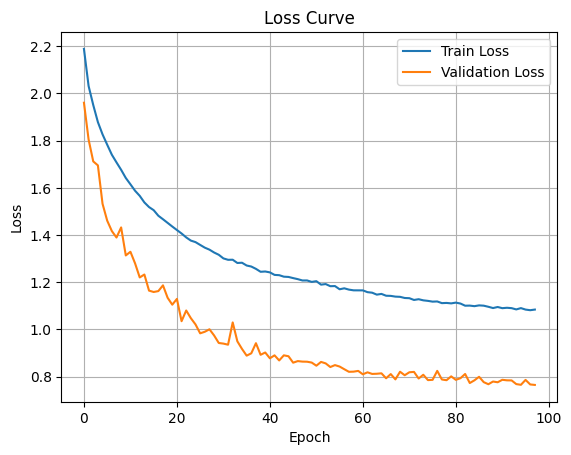

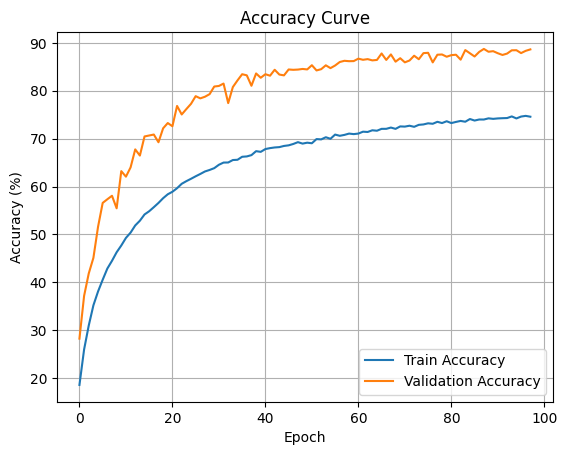

In [ ]:
# Set up device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save model
model.to(device)

# Log training 
train_losses, val_losses = [], []
train_accuracies = []
val_accuracies = []

# Training and Validation Loops 
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss / len(loader), 100 * correct / total

# Main Loop 
patience = 20  # Number of epochs to wait for improvement
early_stop_counter = 0 # Counter for early stopping
epochs = 200
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)


    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        early_stop_counter=0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")
    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epochs.")

    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining Complete")

# Print Final Averages 
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)

print("\nFinal Averages Over All Epochs")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"Average Val   Loss: {avg_val_loss:.4f}")
print(f"Average Val   Accuracy: {avg_val_acc:.2f}%")


# Plot results

# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")

# Plot Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")

print("Plots saved: loss_curve.png and accuracy_curve.png")
